TRAINING

In [ ]:
from train_full import train_all
import torch

TRAIN_PATH = r"data_preparation\train_val"
SAVE_PATH = "trained_models"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
results = train_all(TRAIN_PATH, SAVE_PATH, DEVICE)



===== RATIO 10_1_1 =====

===== RATIO 1_1_1 =====

--- Training 1_1_1/set_2 ---
[Epoch 1] Train=0.5551 | Val=0.4240 | auc=0.9479 | balanced_acc=0.8348 | mcc=0.7470 | acc=0.8312 | f1_macro=0.8328 | f1_micro=0.8312
[Epoch 2] Train=0.4183 | Val=0.3938 | auc=0.9547 | balanced_acc=0.8470 | mcc=0.7655 | acc=0.8432 | f1_macro=0.8441 | f1_micro=0.8432
[Epoch 3] Train=0.3689 | Val=0.3827 | auc=0.9576 | balanced_acc=0.8563 | mcc=0.7789 | acc=0.8523 | f1_macro=0.8535 | f1_micro=0.8523
[Epoch 4] Train=0.3285 | Val=0.3635 | auc=0.9616 | balanced_acc=0.8647 | mcc=0.7928 | acc=0.8618 | f1_macro=0.8629 | f1_micro=0.8618
[Epoch 5] Train=0.2940 | Val=0.3651 | auc=0.9621 | balanced_acc=0.8674 | mcc=0.7958 | acc=0.8635 | f1_macro=0.8645 | f1_micro=0.8635
[Epoch 6] Train=0.2603 | Val=0.3618 | auc=0.9645 | balanced_acc=0.8721 | mcc=0.8042 | acc=0.8690 | f1_macro=0.8697 | f1_micro=0.8690
[Epoch 7] Train=0.2287 | Val=0.3905 | auc=0.9641 | balanced_acc=0.8709 | mcc=0.8024 | acc=0.8672 | f1_macro=0.8674 | f1_

When finished, open cmd terminal:

tensorboard --logdir=training\trained_models

RESULT

In [ ]:
results

,ratio,set,auc,balanced_acc,mcc,acc,f1_macro,f1_micro
0,1_1_1,set_2,0.964499,0.872087,0.804215,0.868963,0.869705,0.868963
1,1_1_1,set_3,0.966641,0.875534,0.810363,0.873942,0.875432,0.873942
2,1_1_1,set_4,0.964919,0.871994,0.804093,0.869860,0.871336,0.869860
3,1_1_1,set_5,0.966750,0.878052,0.813487,0.875734,0.876797,0.875734
4,1_1_1,set_6,0.968515,0.880808,0.818145,0.878921,0.879700,0.878921
5,1_1_1,set_7,0.968777,0.875046,0.808098,0.872050,0.872373,0.872050
6,1_1_1,set_8,0.968670,0.881738,0.818699,0.879419,0.880243,0.879419
7,1_1_1,set_9,0.968288,0.880669,0.816856,0.878024,0.879113,0.878024
8,2_1_1,set_1,0.966332,0.875978,0.800670,0.877715,0.874739,0.877715
9,2_1_1,set_10,0.966822,0.883830,0.801777,0.876684,0.874230,0.876684


In [ ]:
avg_metrics = results.drop(columns=["set"]).groupby("ratio").mean().reset_index()
avg_metrics

,ratio,auc,balanced_acc,mcc,acc,f1_macro,f1_micro
0,1_1_1,0.967132,0.876991,0.811744,0.874614,0.875587,0.874614
1,2_1_1,0.967912,0.883278,0.806430,0.880387,0.878164,0.880387


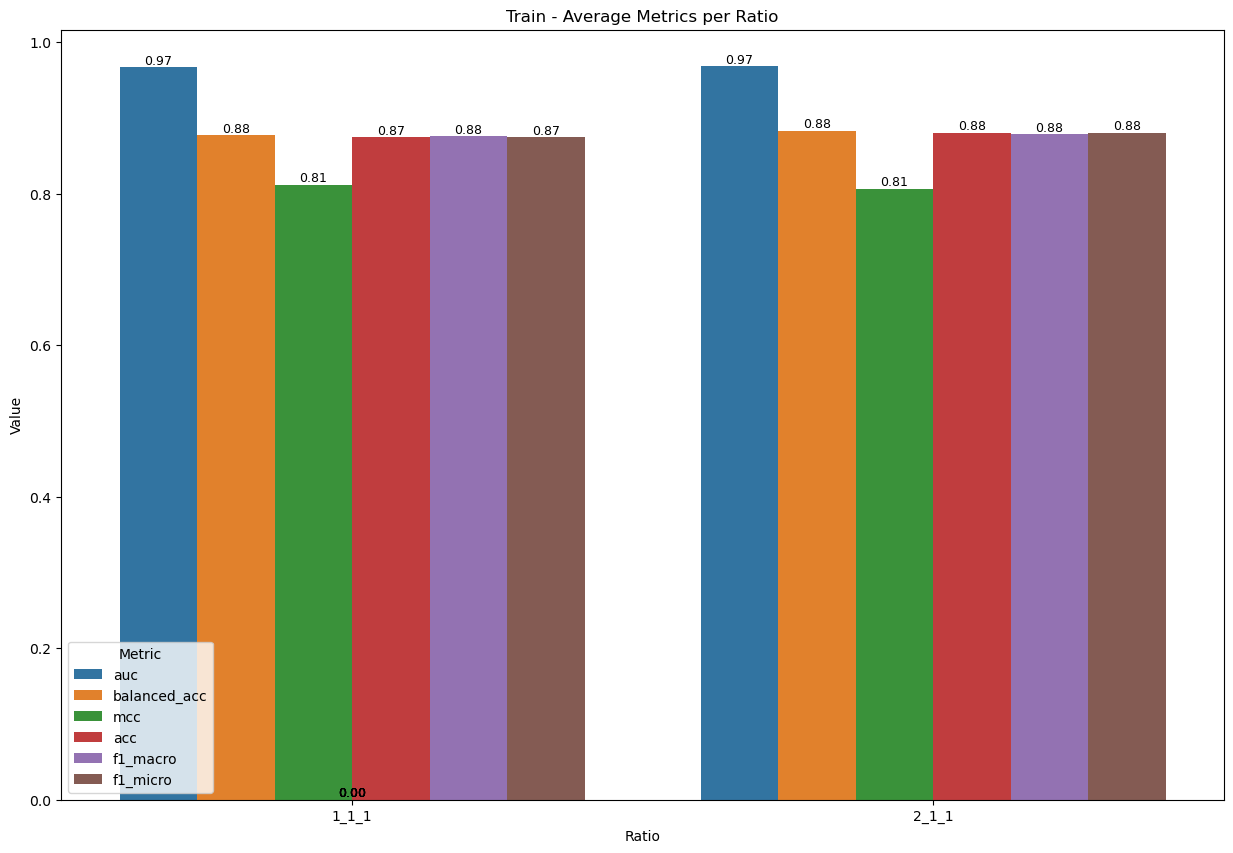

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_long = avg_metrics.melt(id_vars="ratio", var_name="metric", value_name="value")

plt.figure(figsize=(15,10))
ax = sns.barplot(data=avg_long, x="ratio", y="value", hue="metric")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, rotation=0)

plt.title("Train - Average Metrics per Ratio")
plt.ylabel("Value")
plt.xlabel("Ratio")
plt.legend(title="Metric")
plt.show()